# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

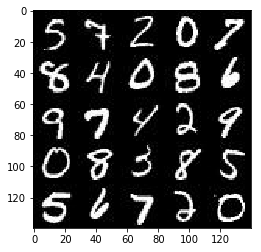

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

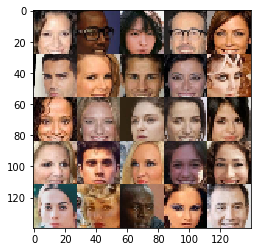

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse): 
        # Input layer 28x28x*
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = False if is_train==True else True
    with tf.variable_scope('generator', reuse=reuse):  
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # out_channel_dim now
        
        out = tf.tanh(logits)
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #input_real, input_z, lr = model_inputs(28, 28, 1, z_dim)
    channels = 3 if data_image_mode == 'RGB' else 1
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #print(batch_images.shape)
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))  
                
                if steps % show_every == 0:
                   show_generator_output(sess, 20, input_z, channels, data_image_mode) 
        
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 4.0147... Generator Loss: 0.0344
Epoch 1/2... Discriminator Loss: 3.1309... Generator Loss: 0.1024
Epoch 1/2... Discriminator Loss: 2.4692... Generator Loss: 0.2618
Epoch 1/2... Discriminator Loss: 2.0308... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 2.0643... Generator Loss: 0.2839
Epoch 1/2... Discriminator Loss: 1.9508... Generator Loss: 0.3216
Epoch 1/2... Discriminator Loss: 1.8986... Generator Loss: 0.5210
Epoch 1/2... Discriminator Loss: 1.8184... Generator Loss: 0.4710
Epoch 1/2... Discriminator Loss: 1.7688... Generator Loss: 0.5730
Epoch 1/2... Discriminator Loss: 1.6837... Generator Loss: 0.5178


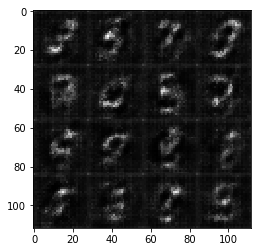

Epoch 1/2... Discriminator Loss: 1.6579... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 1.6787... Generator Loss: 0.5915
Epoch 1/2... Discriminator Loss: 1.6365... Generator Loss: 0.5651
Epoch 1/2... Discriminator Loss: 1.5708... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 1.5325... Generator Loss: 0.6853
Epoch 1/2... Discriminator Loss: 1.5328... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.5784... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.5845
Epoch 1/2... Discriminator Loss: 1.5727... Generator Loss: 0.4756
Epoch 1/2... Discriminator Loss: 1.5889... Generator Loss: 0.5612


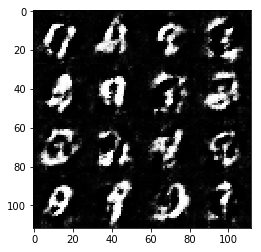

Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.6395
Epoch 1/2... Discriminator Loss: 1.5247... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 1.4798... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.5006... Generator Loss: 0.5069
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.5581
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.6584
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.6236
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 0.6589


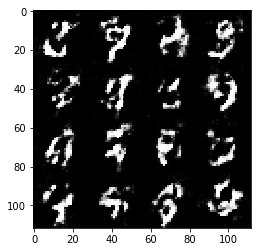

Epoch 1/2... Discriminator Loss: 1.4339... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.5416
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 0.6011
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.6732
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.8690
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.5074
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.6146


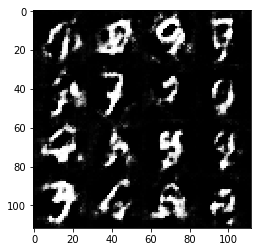

Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.6336
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.6140
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.6580... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.8475


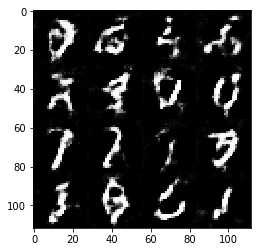

Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.6021
Epoch 1/2... Discriminator Loss: 1.4302... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.6870
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 0.6893
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 1.5188... Generator Loss: 0.6968
Epoch 1/2... Discriminator Loss: 1.5549... Generator Loss: 0.5819
Epoch 1/2... Discriminator Loss: 1.5220... Generator Loss: 0.5952


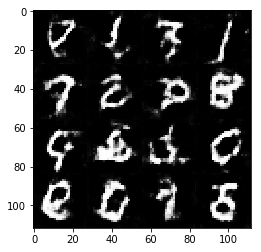

Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.8200
Epoch 1/2... Discriminator Loss: 1.4113... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.5680... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 1.5988... Generator Loss: 0.5658
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.5149... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 0.6561


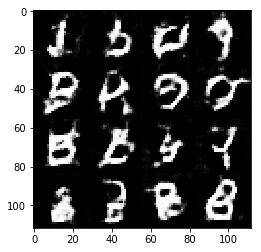

Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.6820
Epoch 1/2... Discriminator Loss: 1.5999... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.5046... Generator Loss: 0.5948
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.4776... Generator Loss: 0.6551
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.8299
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.7390


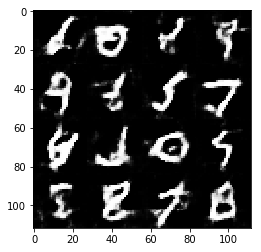

Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.6068
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 1.0703
Epoch 1/2... Discriminator Loss: 1.4882... Generator Loss: 0.5161
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 0.7206


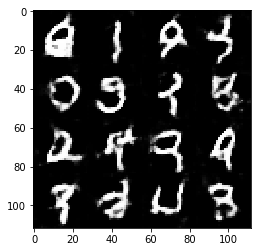

Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.5024
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 0.5970


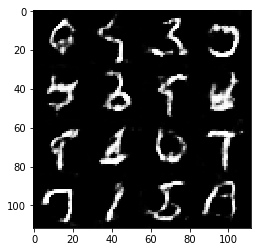

Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.7842
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.6107
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.8320
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.5484
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.6050
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.4575


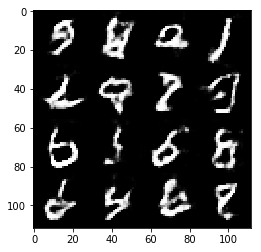

Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.5820
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 0.5621
Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.6037
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.6277
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.5788
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 0.7878


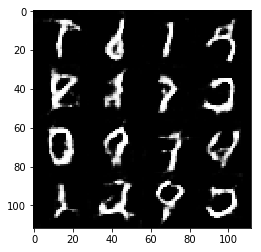

Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.8422
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.4730... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.5638... Generator Loss: 0.4780
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.5985
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.6780
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.8834
Epoch 1/2... Discriminator Loss: 1.4782... Generator Loss: 0.5905


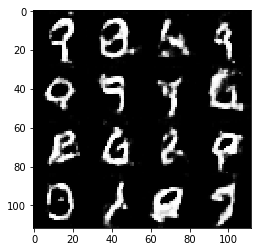

Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.2921... Generator Loss: 0.6445
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.4712
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.6882
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.5168
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.2893... Generator Loss: 0.7932


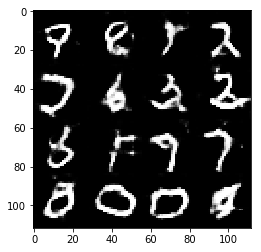

Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 0.7505
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.9685
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.5313
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.6750
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.6289


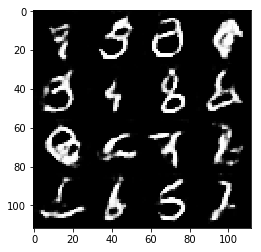

Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.9509
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.6209
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.5510
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.6340
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.4986


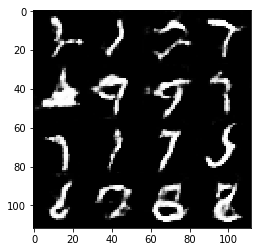

Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.7695... Generator Loss: 0.2999
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.0760
Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 0.4496
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.6657
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 1.0193


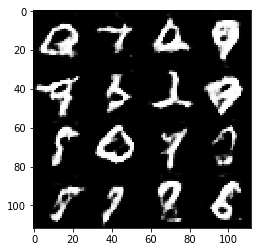

Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.6271
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.6312... Generator Loss: 0.3628
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.7349
Epoch 1/2... Discriminator Loss: 1.4606... Generator Loss: 0.5046
Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 0.4565
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.6499


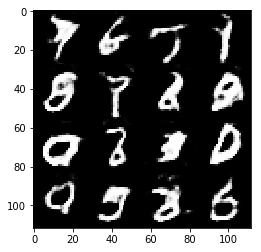

Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 1.2824
Epoch 1/2... Discriminator Loss: 1.1900... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.6713
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.4714
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.5066
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.5992
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.6725


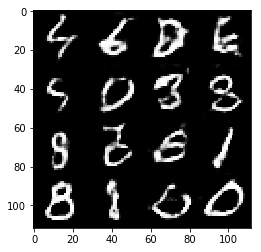

Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.5467
Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.4524
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.6525
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 1.2008


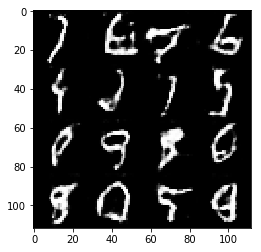

Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 1.4323... Generator Loss: 0.4686
Epoch 2/2... Discriminator Loss: 2.7097... Generator Loss: 2.2824
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 0.9703
Epoch 2/2... Discriminator Loss: 1.2978... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.5245
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.6298
Epoch 2/2... Discriminator Loss: 1.5293... Generator Loss: 0.3997


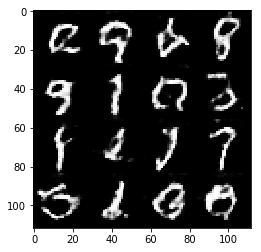

Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 1.1296
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.9016
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.5589
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.4632... Generator Loss: 0.4594
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.6072
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.7747


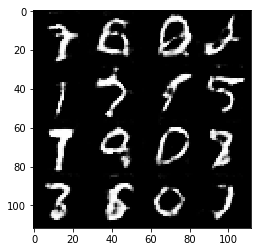

Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.4217... Generator Loss: 0.4722
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.6378
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.8175
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.6440
Epoch 2/2... Discriminator Loss: 1.6458... Generator Loss: 0.3370
Epoch 2/2... Discriminator Loss: 1.7354... Generator Loss: 0.3252
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 0.9961
Epoch 2/2... Discriminator Loss: 1.2055... Generator Loss: 0.7269


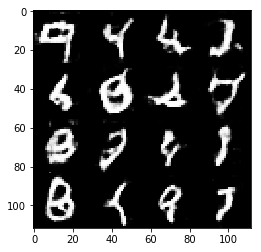

Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.6384
Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 0.4733
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.8739
Epoch 2/2... Discriminator Loss: 1.1081... Generator Loss: 0.9492
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 1.1299... Generator Loss: 0.8074
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.6606
Epoch 2/2... Discriminator Loss: 1.0885... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.7696


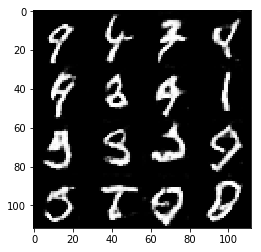

Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.8952
Epoch 2/2... Discriminator Loss: 1.4113... Generator Loss: 0.4815
Epoch 2/2... Discriminator Loss: 1.5753... Generator Loss: 0.3826
Epoch 2/2... Discriminator Loss: 1.0691... Generator Loss: 1.1081
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 0.8306
Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.9540
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.5961
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.6188
Epoch 2/2... Discriminator Loss: 2.0278... Generator Loss: 0.2305


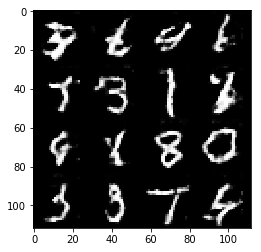

Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.5802
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.4997
Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 1.2214
Epoch 2/2... Discriminator Loss: 1.4452... Generator Loss: 0.4325
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 1.0929


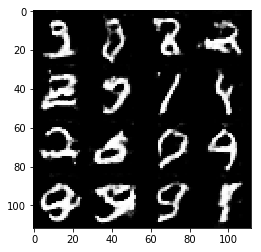

Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 2.2283... Generator Loss: 0.1876
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.9157
Epoch 2/2... Discriminator Loss: 1.1909... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.7688
Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 0.8562
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 1.0588
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 1.1770


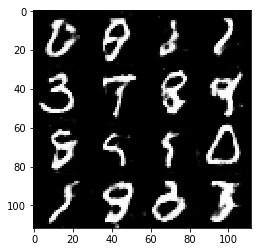

Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.7723
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.5160
Epoch 2/2... Discriminator Loss: 1.5620... Generator Loss: 0.3889
Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.6728
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 0.6525
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 1.1650... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 1.1231


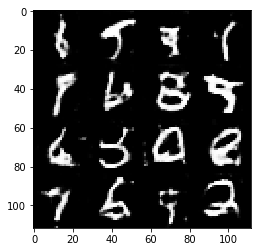

Epoch 2/2... Discriminator Loss: 1.3326... Generator Loss: 0.5329
Epoch 2/2... Discriminator Loss: 1.4447... Generator Loss: 0.4488
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.6138
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.5134
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 0.9015


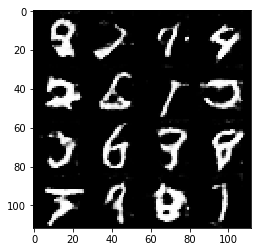

Epoch 2/2... Discriminator Loss: 1.2298... Generator Loss: 0.6205
Epoch 2/2... Discriminator Loss: 0.9425... Generator Loss: 1.3143
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.5794
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.6874
Epoch 2/2... Discriminator Loss: 1.1247... Generator Loss: 0.8983
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.9618
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 1.0871
Epoch 2/2... Discriminator Loss: 2.1806... Generator Loss: 1.1267


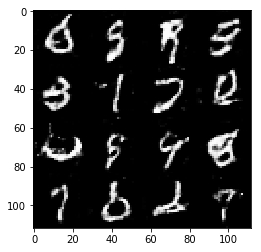

Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.5835
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.8919
Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 0.9727
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 1.1479
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.5144
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 1.0534
Epoch 2/2... Discriminator Loss: 1.1345... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.8567


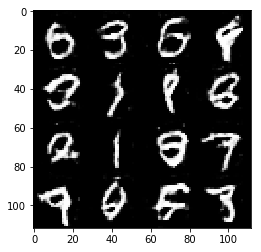

Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 0.9034
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 1.0348
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 1.3359
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.5745
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.5929
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.7556


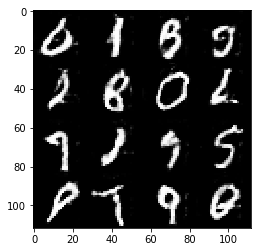

Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.5982
Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.5273... Generator Loss: 0.4781
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 0.9170
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 0.6981
Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.7389
Epoch 2/2... Discriminator Loss: 1.4936... Generator Loss: 0.4408


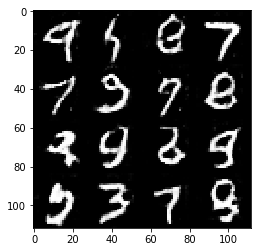

Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 1.0424
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 2.5846... Generator Loss: 2.6656
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 1.0355
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 0.7153
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.6388
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 1.1691


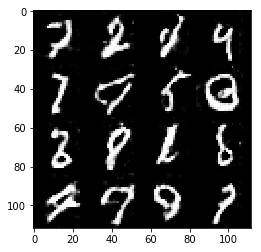

Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 1.0942
Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 0.8237
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.1905... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.6317
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.9342
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.6509


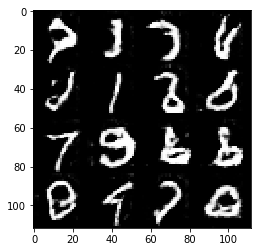

Epoch 2/2... Discriminator Loss: 1.4939... Generator Loss: 0.4567
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.7119
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.6480
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 1.0531... Generator Loss: 1.1170
Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 1.4589... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.8587
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.9838


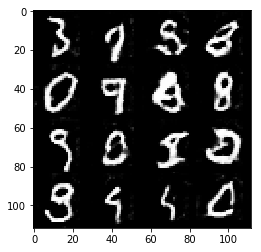

Epoch 2/2... Discriminator Loss: 2.0392... Generator Loss: 0.3035
Epoch 2/2... Discriminator Loss: 1.2174... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.4354
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.0271... Generator Loss: 0.9830
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 0.6428
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.6478


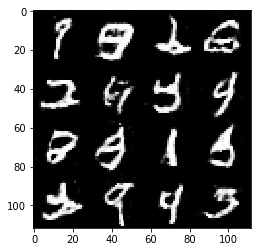

Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 0.6375
Epoch 2/2... Discriminator Loss: 1.5382... Generator Loss: 1.0980
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 1.0104
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 0.6098


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.